In [65]:
# chargement des données de playlist
import numpy as np
data = np.load("./music_2.npy")
len(data)

100000

In [66]:
# récupération uniquement des identifiant de morceaux // suppression des identifiant d'artiste
playlist_track = [list(filter(lambda w: w.split("_")[0]==u"track",playlist)) for playlist in data]

In [67]:
# nombre de morceaux != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

In [68]:
# nombre d'occurence de chaque morceaux ?
track_counts = dict((tracks[i],0) for i in range(0, Vt))
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [69]:
# filtrage des morceaux très peu fréquents
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 7, playlist)) for playlist in playlist_track]
track_f = np.unique(np.concatenate(playlist_track_filter))
Vt = len(track_f)

In [70]:
# construction d'un dict id_morceaux id [0,Vt]
track_dict = dict((track_f[i],i) for i in range(0, Vt))
# conversion des playlisat en liste d'entier
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

In [71]:
# import de Keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

In [72]:
# hyper-paramètres de word2vec :
# dimension de l'espace latent
vector_dim = 50
# taille de la fenêtre de voisinage
window_width = 5
# sur-échantillonage des exemples négatifs
neg_sample = 4.
# taille des mini-batch
min_batch_size = 50
# coeff pour la loi de tirage des exemple negatif
samp_coef = -0.1

In [73]:
# comptage du nombre d'occurences des morceaux dans les playlist filtrées
tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
for p in playlist_track_filter:
    for t in p:
        tracks_counts_f[t]=tracks_counts_f[t]+1;
# construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
sptn_tracks=np.power(spt_tracks,samp_coef)
sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

In [74]:
# construction du réseau word2vec

# entrée deux entier (couple de morceaux)
input_target_t = Input((1,), dtype='int32')
input_context_t = Input((1,), dtype='int32')

# définition de l'embeding
embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
# projection du premier morceau
target_t = embedding_t_t(input_target_t)
target_t = Reshape((vector_dim, 1))(target_t)

# projection du second morceaux
context_t = embedding_t_t(input_context_t)
context_t = Reshape((vector_dim, 1))(context_t)

# calcul de la sortie
dot_product_t = Dot(axes=0)([target_t, context_t])
dot_product_t = Reshape((1,))(dot_product_t)
output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

# definition du modèle
SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')

In [75]:
# définition du générateur de couple de morceaux (y=0 <-> aléatoire, y=1 <-> proche dans une playlist)
import random
def track_ns_generator(corpus_num,nbm):
    while 1:
        Data=[]
        Labels=[]
        for i, doc in enumerate(random.sample(corpus_num,nbm)):
            data, labels = skipgrams(sequence=doc, vocabulary_size=Vt, window_size=window_width, negative_samples=neg_sample,sampling_table=sptn_tracks)
            if (len(data)>0):
                Data.append(np.array(data, dtype=np.int32))
                Labels.append(np.array(labels, dtype=np.int32))
        Data=np.concatenate(Data)
        Labels=np.concatenate(Labels)
        x=[Data[:,0],Data[:,1]]
        y=Labels
        yield (x,y)

In [76]:
# ensemble de test et d'apprentissage
index_tst = np.random.choice(100000,10000)
index_app  = np.setdiff1d(range(100000),index_tst)

play_app   = [corpus_num_track[i] for i in index_app]
play_tst  = [corpus_num_track[i] for i in index_tst]


In [77]:
# apprentissage
hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,50)

Epoch 1/50
200/200 [==============================] - 6s 28ms/step - loss: 0.6652
Epoch 2/50
200/200 [==============================] - 5s 23ms/step - loss: 0.6134
Epoch 3/50
200/200 [==============================] - 5s 23ms/step - loss: 0.5524
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 0.5063
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4765
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4520
Epoch 7/50
200/200 [==============================] - 5s 23ms/step - loss: 0.4312
Epoch 8/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4146
Epoch 9/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4026
Epoch 10/50
200/200 [==============================] - 5s 24ms/step - loss: 0.3827
Epoch 11/50
200/200 [==============================] - 5s 23ms/step - loss: 0.3708
Epoch 12/50
200/200 [==============================] - 5s 23ms/step - loss: 0.3599
Epoch 13/50
2

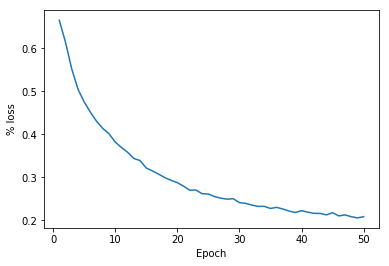

In [79]:
# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = SkipGram_t.get_weights()[0]

# Affichage des loss
history = hist.history['loss']
import matplotlib.pyplot as plt

gr = plt.plot(range(1,len(history) + 1, 1),history)
xl = plt.xlabel("Epoch")
yl = plt.ylabel("% loss")
plt.show()

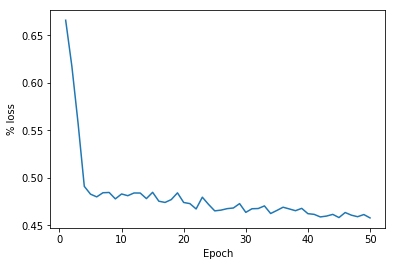

In [64]:
# Cas ou l'algorithme n'a pas convergé : 
gr = plt.plot(range(1,len(history) + 1, 1),history)
xl = plt.xlabel("Epoch")
yl = plt.ylabel("% loss")
plt.show()

Nous pouvons voir dans cet example que l'algorithme n'a pas convergé.<br>
En effet, le nombre de loss avoisine encore les 50% !

## Prediction

In [16]:
from sklearn.metrics import pairwise_distances

In [17]:
# fonction retpournant les indices des s plus proches voisins des seeds dans la matrice X
# a vous de jouer avec pairwise_distances, np.min, np.argsort,...
def predict(seeds,s,X):
    V = X.shape[0]
    others = np.setdiff1d(range(V),seeds)
    D = pairwise_distances(X[seeds,:],X[others,:],'cosine')
    return others[np.argsort(np.min(D,0))[:s]]

In [18]:
# exemple pour 4 suggestions avec les 2 premiers morceaux en seeds 
pr=predict([0,1],4,vectors_tracks)
pr

array([ 6334, 10131, 16333,     9])

In [19]:
# estimation des performances
# hit@10
# nombre de bonne prediction
goodpred = []
# nombre de predictions faites
nbpred   = []
# pour chaque playlist
for p in play_tst:
    # si au moins deux chansons
    if (len(p)>1):
        # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
        seeds  = p[:np.min([5,len(p)-1])]
        # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
        topred = p[np.min([5,len(p)-1]):]
        # construction des suggestions 10 suggestions par morceaux a predire
        prediction = predict(seeds,10*len(topred),vectors_tracks)
        # comptage du nombre de morceaux présent dans nos suggestions
        goodpred.append(len(np.intersect1d(prediction,topred)))
        # stockage du nombre de predictions
        nbpred.append(len(topred))
# proportions de morceux présents dans nos suggestions
hitat10 = np.sum(goodpred)/np.sum(nbpred)

In [20]:
hitat10

0.28301396894635716

# A faire

- faire quelque graphique sen particulier pour discuter le choix de n'avoir garder que les morceaux présents dans plus de sept playlists
- coder la fonction predict permetant de trouver les morceaux les plus proches des seeds (dans un premier temps de manière simple en utilisant la fonction pairwise_dist de sklearn)
- tester l'influence des différents type de distance sur les les performances en terme de hit@10
- vous pourrez ensuite essayé d'optimiser cette recherche https://scikit-learn.org/stable/modules/neighbors.html
- faites varier un hyper-paramètres sur une plage raisonable 
- faire un graphique de hit@10 en fonction des valeurs de l'hyperparamètre
- faire de même avec un second
- proposer des valeures finales pour les hyper-paramètres
- joindre avec les meta-données, url des morceaux ....
- exporter // faire le liens avec le front-end

## Aide

In [21]:
# aide jointure
import pandas as pd
tr_meta=pd.read_csv("./Tracks.csv")
jdf = pd.DataFrame({"id":track_f,"index":range(Vt)})
jdf["deezer_id"]=jdf["id"].apply(lambda x: float(x.split("_")[1]))

In [22]:
trj_meta = tr_meta.merge(jdf, left_on="id",right_on="deezer_id")
trj_meta.set_index("index",inplace=True)

In [23]:
#trj_meta[trj_meta['title'].str.contains('Stand')]

In [24]:
trj_meta

Unnamed: 0                                              album  \
index                                                                  
0               0  {u'title': u'Alone', u'type': u'album', u'rele...   
1               1  {u'title': u'V (Deluxe)', u'type': u'album', u...   
2               2  {u'title': u'V (Deluxe)', u'type': u'album', u...   
3               3  {u'title': u'V (Deluxe)', u'type': u'album', u...   
4               4  {u'title': u'V (Deluxe)', u'type': u'album', u...   
5               5  {u'title': u'V (Deluxe)', u'type': u'album', u...   
6               6  {u'title': u'V (Deluxe)', u'type': u'album', u...   
7               7  {u'title': u'V (Deluxe)', u'type': u'album', u...   
8               8  {u'title': u'V (Deluxe)', u'type': u'album', u...   
9               9  {u'title': u'V (Deluxe)', u'type': u'album', u...   
10             14  {u'title': u'Ain't Nobody (Loves Me Better) (R...   
11             18  {u'title': u'V', u'type': u'album', u'release_...   
12             19  {u'title': u'V', u'type': u'album', u'release_...   
13             21  {u'title': u'V', u'type': u'album', u'release_...   
14             22  {u'title': u'V', u'type': u'album', u'release_...   
15             23  {u'title': u'V', u'type': u'album', u'release_...   
16             24  {u'title': u'Policeman - EP', u'type': u'album...   
17             25  {u'title': u'What Did You Expect from the Vacc...   
18             26  {u'title': u'Times', u'type': u'album', u'rele...   
19             27  {u'title': u'Everyday', u'type': u'album', u'r...   
20             32  {u'title': u'Amanecer', u'type': u'album', u'r...   
21             33  {u'title': u'Amanecer', u'type': u'album', u'r...   
22             34  {u'title': u'Amanecer', u'type': u'album', u'r...   
23             35  {u'title': u'Ao Vivo em São Paulo', u'type': u...   
24             36  {u'title': u'Ao Vivo em São Paulo', u'type': u...   
25             37  {u'title': u'Vem, Esta É a Hora (Ao Vivo)', u'...   
26             38  {u'title': u'Vem, Esta É a Hora (Ao Vivo)', u'...   
27             39  {u'title': u'Ao Vivo no Hangar', u'type': u'al...   
28             41  {u'title': u'Madame Libertánah', u'type': u'al...   
29             42  {u'title': u'Le prince de la ville', u'type': ...   
...           ...                                                ...   
22703       15204  {u'title': u'Bernstein Sibelius - The Symphoni...   
22704       15205  {u'title': u'Battlecry', u'type': u'album', u'...   
22705       15207  {u'title': u'Roses', u'type': u'album', u'rele...   
22706       15209  {u'title': u'Perreología', u'type': u'album', ...   
22707       15214  {u'title': u'Dawn EP', u'type': u'album', u're...   
22708       15215  {u'title': u'Another You', u'type': u'album', ...   
22709       15217  {u'title': u'Icon', u'type': u'album', u'relea...   
22710       15218  {u'title': u'Reality', u'type': u'album', u're...   
22711       15220  {u'title': u'Dead', u'type': u'album', u'relea...   
22712       15221  {u'title': u'Room with view Ep', u'type': u'al...   
22713       15224  {u'title': u'Sheer Heart Attack (2011 Remaster...   
22714       15225  {u'title': u'A Night At The Opera (2011 Remast...   
22715       15226  {u'title': u'A Night At The Opera (2011 Remast...   
22716       15227  {u'title': u'A Night At The Opera (Deluxe Edit...   
22717       15228  {u'title': u'Blurryface', u'type': u'album', u...   
22718       15229  {u'title': u'Blurryface', u'type': u'album', u...   
22719       15230  {u'title': u'Blurryface', u'type': u'album', u...   
22720       15231  {u'title': u'Blurryface', u'type': u'album', u...   
22721       15232  {u'title': u'Blurryface', u'type': u'album', u...   
22722       15233  {u'title': u'Blurryface', u'type': u'album', u...   
22723       15234  {u'title': u'Blurryface', u'type': u'album', u...   
22724       15235  {u'title': u'Blurryface', u'type': u'album', u...   
22725       15236  {u'title': u'Blurryface', u'

In [25]:
#aide predict_opt
#créer un kd-tree
from sklearn.neighbors import KDTree
kdt = KDTree(vectors_tracks, leaf_size=30, metric='euclidean')

In [26]:
#fonction de recherche a compléter
#vérifer la cohérences des résulats avec predict
def predict_opt(seeds,s,X,kdt):
    dist, ind = kdt.query(X[seeds,:], k=s+1)
    return ind[0]
    #return ind

In [27]:
predict_opt([15218,4],4,vectors_tracks,kdt)

array([15218, 11578,  2920, 11175,  4714], dtype=int64)

In [28]:
predict([9152],4,vectors_tracks)

array([18102, 19030,  4347, 21250])

In [29]:
for p in play_tst:
    # si au moins deux chansons
    if (len(p)>1):
        # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
        seeds  = p[:np.min([5,len(p)-1])]
        # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
        topred = p[np.min([5,len(p)-1]):]
        # construction des suggestions 10 suggestions par morceaux a predire
        prediction = predict_opt(seeds,10*len(topred),vectors_tracks,kdt)
        # comptage du nombre de morceaux présent dans nos suggestions
        goodpred.append(len(np.intersect1d(prediction,topred)))
        # stockage du nombre de predictions
        nbpred.append(len(topred))
# proportions de morceux présents dans nos suggestions
hitat10 = np.sum(goodpred)/np.sum(nbpred)

In [30]:
hitat10

0.2420548372020564

In [31]:
# vérification de la cohérences des résultats des suggestion

In [32]:
trj_meta.sort_values(by=['rank'],ascending=False)["title"].head(20)

index
6346                                     Shape of You
9152                  I Will Survive (Single Version)
7090                                      Look At Me!
20466    I Will Survive (Lalala), Original Radio Edit
11875                                           IDGAF
7215                                          Perfect
7131                         Something Just Like This
20170           Magic In The Air (feat. Ahmed Chawki)
7500                                        Despacito
6458                                            Faded
15120                                  Jocelyn Flores
11879                                       New Rules
3043                                        One Dance
13197                    De Trás Pra Frente (Ao Vivo)
14386        Meant to Be (feat. Florida Georgia Line)
12572                                       Me Rehúso
15126                                       Fuck Love
15122              Everybody Dies In Their Nightmares
11523                 

In [33]:
# les voisins de i will survive ?
b=predict([15218],4,vectors_tracks)
trj_meta.loc[b,"title"]

index
4714     La Roma (feat. Sadek)
11175                À part ça
15133              La Provence
11578                     Loin
Name: title, dtype: object

In [34]:
# les voisins de i will survive ?
b=predict_opt([9152, 22000],8,vectors_tracks,kdt)
trj_meta.loc[b, ["title", "preview"]]

title  \
index                                                      
9152                     I Will Survive (Single Version)   
18102                                      Like A Prayer   
4347                                      I'm So Excited   
19030                       YMCA (Original Version 1978)   
20532                                     Got to Be Real   
21250                                          Mamma Mia   
16742                        Girls Just Want to Have Fun   
18532  Good Times (2006 Remastered Version Original 1...   
19029                In the Navy (Original Version 1979)   

                                                 preview  
index                                                     
9152   http://cdn-preview-e.deezer.com/stream/c-e4855...  
18102  http://cdn-preview-a.deezer.com/stream/c-ac916...  
4347   http://cdn-preview-7.deezer.com/stream/c-73964...  
19030  http://cdn-preview-b.deezer.com/stream/c-bb2ca...  
20532  http://cdn-preview-4.deezer.com/stream/c-4e22d...  
21250  http://cdn-preview-8.deezer.com/stream/c-8b713...  
16742  http://cdn-preview-a.deezer.com/stream/c-a8c06...  
18532  http://cdn-preview-5.deezer.com/stream/c-549af...  
19029  http://cdn-preview-0.deezer.com/stream/c-0b506...

In [35]:
# un peu de musique
import IPython
IPython.display.Audio(trj_meta.loc[19030,"preview"])

In [36]:
trj_meta.to_dict()["title"][4]

'Leaving California'

In [37]:
b

array([ 9152, 18102,  4347, 19030, 20532, 21250, 16742, 18532, 19029],
      dtype=int64)

# Result :
Le résultat final des hyper paramètres choisi sont les suivants :
## word2vec 
___dimension de l'espace latent___
* vector_dim = 25

___Taille de la fenêtre de voisinage___
* window_width = 5

___sur-échantillonage des exemples négat___
* neg_sample = 4.

___taille des mini-batch___
* min_batch_size = 25

___coeff pour la loi de tirage des exemple negatif___
* samp_coef = -0.1

___KDTree metrics___ : Euclidien

In [38]:
import numpy as np
# import de Keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree

In [39]:
from sklearn.neighbors import NearestNeighbors

def predict_new(seeds,s,X):
    nbrs = NearestNeighbors(n_neighbors=s + 1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X[seeds,:])
    return indices[0]

## Valeurs des hyper-parametres

In [40]:
# hyper-paramètres de word2vec :
# dimension de l'espace latent
vector_dim = 25
# taille de la fenêtre de voisinage
window_width = 5
# sur-échantillonage des exemples négatifs
neg_sample = 4.
# taille des mini-batch
min_batch_size = 25
# coeff pour la loi de tirage des exemple negatif
samp_coef = -0.1

generate tracks tab
0.022666168782673638
0.09790624042488
0.0843723010828886
0.031265496965546556
0.11067639756226018
0.03360512673561362
0.09992276758369065
0.1311204943933335
0.12430317022354863
0.04965953009017852


<function matplotlib.pyplot.show(*args, **kw)>

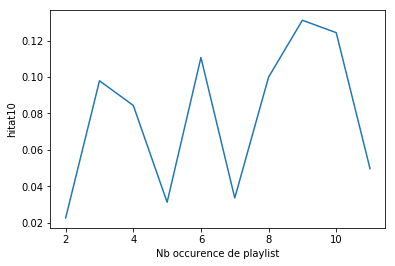

In [41]:
import random
def track_ns_generator(corpus_num,nbm):
    while 1:
        Data=[]
        Labels=[]
        for i, doc in enumerate(random.sample(corpus_num,nbm)):
            data, labels = skipgrams(sequence=doc, vocabulary_size=Vt, window_size=window_width, negative_samples=neg_sample,sampling_table=sptn_tracks)
            if (len(data)>0):
                Data.append(np.array(data, dtype=np.int32))
                Labels.append(np.array(labels, dtype=np.int32))
        Data=np.concatenate(Data)
        Labels=np.concatenate(Labels)
        x=[Data[:,0],Data[:,1]]
        y=Labels
        yield (x,y)

tab_playlist_track_filter = []
print("generate tracks tab")
for i in range(2,12) :
    playlist_track_filter_tmp = [list(filter(lambda a : track_counts[a]> i, playlist)) for playlist in playlist_track]
    tab_playlist_track_filter.append(playlist_track_filter_tmp)

hist_hitat10 = []
    
for playlist_track_filter_ in tab_playlist_track_filter:

    track_f = np.unique(np.concatenate(playlist_track_filter_))
    Vt = len(track_f)
    track_dict = dict((track_f[i],i) for i in range(0, Vt))
    corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter_]

    # comptage du nombre d'occurences des morceaux dans les playlist filtrées
    tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
    for p in playlist_track_filter_:
        for t in p:
            tracks_counts_f[t]=tracks_counts_f[t]+1;
    # construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
    spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
    sptn_tracks=np.power(spt_tracks,samp_coef)
    sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
    sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

    # construction du réseau word2vec

    # entrée deux entier (couple de morceaux)
    input_target_t = Input((1,), dtype='int32')
    input_context_t = Input((1,), dtype='int32')

    # définition de l'embeding
    embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
    # projection du premier morceau
    target_t = embedding_t_t(input_target_t)
    target_t = Reshape((vector_dim, 1))(target_t)

    # projection du second morceaux
    context_t = embedding_t_t(input_context_t)
    context_t = Reshape((vector_dim, 1))(context_t)

    # calcul de la sortie
    dot_product_t = Dot(axes=0)([target_t, context_t])
    dot_product_t = Reshape((1,))(dot_product_t)
    output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

    # definition du modèle
    SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
    SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')

    # ensemble de test et d'apprentissage
    index_tst = np.random.choice(100000,10000)
    index_app  = np.setdiff1d(range(100000),index_tst)

    play_app   = [corpus_num_track[i] for i in index_app]
    play_tst  = [corpus_num_track[i] for i in index_tst]

    hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,5,verbose=0)

    # récupérations des positions des morceaux dans l'espace de projection
    vectors_tracks = SkipGram_t.get_weights()[0]

    new_kdt = KDTree(vectors_tracks, leaf_size=30, metric='euclidean')
    
    # estimation des performances
    # hit@10
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = predict_opt(seeds,10*len(topred),vectors_tracks,new_kdt)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    hitat10 = np.sum(goodpred)/np.sum(nbpred)
    print(hitat10)
    hist_hitat10.append(hitat10)
   
   
gr = plt.plot(range(2,len(hist_hitat10) + 2, 1),hist_hitat10)
xl = plt.xlabel("Nb occurence de playlist")
yl = plt.ylabel("hitat10")
plt.show



Avec le calcul des hit@10 pour le nombre d'occurence de musique dans les playlists, nous ne pouvons pas conclure sur le fait d'utiliser au moins 7 morceaux.

Nous allons donc passer par une autre approche

## Pertinence de la quantité de valeurs

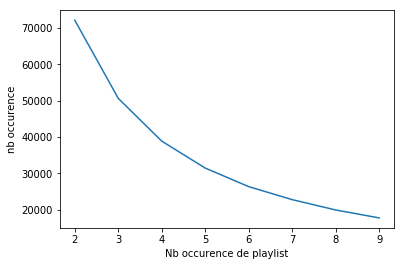

In [42]:
list_playlist = []

for nb in range (2,10):
    playlist_track_filter = [list(filter(lambda a : track_counts[a]> nb, playlist)) for playlist in playlist_track]
    track_f = np.unique(np.concatenate(playlist_track_filter))
    Vt = len(track_f)
    list_playlist.append(Vt)

gr = plt.plot(range(2,len(list_playlist) + 2, 1),list_playlist)
xl = plt.xlabel("Nb occurence de playlist")
yl = plt.ylabel("nb occurence")
plt.show()

## window_width variation
Nous allons ici tester l'hyper-parametre window_width, et le faire varier sur la plage [2,3,4,5]

Editing window_width
0.04094135666107036
0.046160558464223386
0.20731743889638626
0.212741371445948
0.06573758339510749


<function matplotlib.pyplot.show(*args, **kw)>

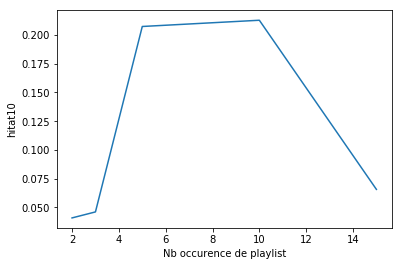

In [45]:
# hyper-paramètres de word2vec :
# dimension de l'espace latent
vector_dim = 25
# taille de la fenêtre de voisinage
window_width = 5
# sur-échantillonage des exemples négatifs
neg_sample = 4.
# taille des mini-batch
min_batch_size = 25
# coeff pour la loi de tirage des exemple negatif
samp_coef = -0.1
print("Editing window_width")

window_width_array = [2,3,5,10,15]
hist_hitat10 = []

for val in window_width_array:
    
    window_width = val
    # comptage du nombre d'occurences des morceaux dans les playlist filtrées
    tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
    for p in playlist_track_filter:
        for t in p:
            tracks_counts_f[t]=tracks_counts_f[t]+1;
    # construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
    spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
    sptn_tracks=np.power(spt_tracks,samp_coef)
    sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
    sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

    # construction du réseau word2vec

    # entrée deux entier (couple de morceaux)
    input_target_t = Input((1,), dtype='int32')
    input_context_t = Input((1,), dtype='int32')

    # définition de l'embeding
    embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
    # projection du premier morceau
    target_t = embedding_t_t(input_target_t)
    target_t = Reshape((vector_dim, 1))(target_t)

    # projection du second morceaux
    context_t = embedding_t_t(input_context_t)
    context_t = Reshape((vector_dim, 1))(context_t)

    # calcul de la sortie
    dot_product_t = Dot(axes=0)([target_t, context_t])
    dot_product_t = Reshape((1,))(dot_product_t)
    output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

    # definition du modèle
    SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
    SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')

    # ensemble de test et d'apprentissage
    index_tst = np.random.choice(100000,10000)
    index_app  = np.setdiff1d(range(100000),index_tst)

    play_app   = [corpus_num_track[i] for i in index_app]
    play_tst  = [corpus_num_track[i] for i in index_tst]

    hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,50,verbose=0)

    # récupérations des positions des morceaux dans l'espace de projection
    vectors_tracks = SkipGram_t.get_weights()[0]

    new_kdt = KDTree(vectors_tracks, leaf_size=30, metric='euclidean')
    
    # estimation des performances
    # hit@10
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = predict_opt(seeds,10*len(topred),vectors_tracks,new_kdt)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    hitat10 = np.sum(goodpred)/np.sum(nbpred)
    print(hitat10)
    hist_hitat10.append(hitat10)
   
   
gr = plt.plot(window_width_array,hist_hitat10)
xl = plt.xlabel("Nb occurence de playlist")
yl = plt.ylabel("hitat10")
plt.show

In [ ]:
# 0.0390730674016793
# 0.17813199841918062
# 0.19271172744571594
# 0.052550874548431534
# 0.19733243024982416

0.17306998556998557
0.19088257199602782
0.05815502086477848
0.05454440064920009
0.20485533754572663


<function matplotlib.pyplot.show(*args, **kw)>

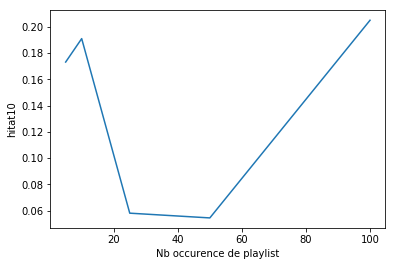

In [46]:
vector_dim_array = [5,10,25,50,100]
hist_hitat10 = []

# hyper-paramètres de word2vec :
# dimension de l'espace latent
vector_dim = 25
# taille de la fenêtre de voisinage
window_width = 5
# sur-échantillonage des exemples négatifs
neg_sample = 4.
# taille des mini-batch
min_batch_size = 25
# coeff pour la loi de tirage des exemple negatif
samp_coef = -0.1



for val in vector_dim_array:
    
    vector_dim = val
    # comptage du nombre d'occurences des morceaux dans les playlist filtrées
    tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
    for p in playlist_track_filter:
        for t in p:
            tracks_counts_f[t]=tracks_counts_f[t]+1;
    # construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
    spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
    sptn_tracks=np.power(spt_tracks,samp_coef)
    sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
    sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

    # construction du réseau word2vec

    # entrée deux entier (couple de morceaux)
    input_target_t = Input((1,), dtype='int32')
    input_context_t = Input((1,), dtype='int32')

    # définition de l'embeding
    embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
    # projection du premier morceau
    target_t = embedding_t_t(input_target_t)
    target_t = Reshape((vector_dim, 1))(target_t)

    # projection du second morceaux
    context_t = embedding_t_t(input_context_t)
    context_t = Reshape((vector_dim, 1))(context_t)

    # calcul de la sortie
    dot_product_t = Dot(axes=0)([target_t, context_t])
    dot_product_t = Reshape((1,))(dot_product_t)
    output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

    # definition du modèle
    SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
    SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')

    # ensemble de test et d'apprentissage
    index_tst = np.random.choice(100000,10000)
    index_app  = np.setdiff1d(range(100000),index_tst)

    play_app   = [corpus_num_track[i] for i in index_app]
    play_tst  = [corpus_num_track[i] for i in index_tst]

    hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,50,verbose=0)

    # récupérations des positions des morceaux dans l'espace de projection
    vectors_tracks = SkipGram_t.get_weights()[0]

    new_kdt = KDTree(vectors_tracks, leaf_size=30, metric='euclidean')
    
    # estimation des performances
    # hit@10
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = predict_opt(seeds,10*len(topred),vectors_tracks,new_kdt)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    hitat10 = np.sum(goodpred)/np.sum(nbpred)
    print(hitat10)
    hist_hitat10.append(hitat10)
   
   
gr = plt.plot(vector_dim_array,hist_hitat10)
xl = plt.xlabel("Nb occurence de playlist")
yl = plt.ylabel("hitat10")
plt.show

## Test modification algo KDTree

0.04658728210164498
0.04753866928553892
0.040142401178492514


<function matplotlib.pyplot.show(*args, **kw)>

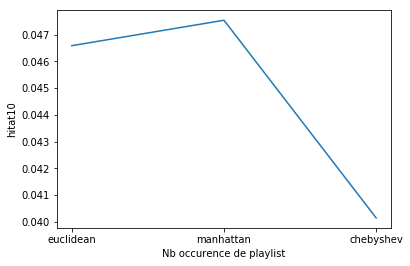

In [47]:
# Hyper parametres par défaut
vector_dim = 50
window_width = 5
neg_sample = 4.
min_batch_size = 50
samp_coef = -0.1

tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
for p in playlist_track_filter:
    for t in p:
        tracks_counts_f[t]=tracks_counts_f[t]+1;
# construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
sptn_tracks=np.power(spt_tracks,samp_coef)
sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

# construction du réseau word2vec

# entrée deux entier (couple de morceaux)
input_target_t = Input((1,), dtype='int32')
input_context_t = Input((1,), dtype='int32')

# définition de l'embeding
embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
# projection du premier morceau
target_t = embedding_t_t(input_target_t)
target_t = Reshape((vector_dim, 1))(target_t)

# projection du second morceaux
context_t = embedding_t_t(input_context_t)
context_t = Reshape((vector_dim, 1))(context_t)

# calcul de la sortie
dot_product_t = Dot(axes=0)([target_t, context_t])
dot_product_t = Reshape((1,))(dot_product_t)
output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

# definition du modèle
SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')

# ensemble de test et d'apprentissage
index_tst = np.random.choice(100000,10000)
index_app  = np.setdiff1d(range(100000),index_tst)

play_app   = [corpus_num_track[i] for i in index_app]
play_tst  = [corpus_num_track[i] for i in index_tst]

hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,50,verbose=0)

# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = SkipGram_t.get_weights()[0]

metrics = ['euclidean', 'manhattan', 'chebyshev']
hist_hitat10 = []
for metric_ in metrics:
    new_kdt = KDTree(vectors_tracks, leaf_size=30, metric=metric_)

    # estimation des performances
    # hit@10
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = predict_opt(seeds,10*len(topred),vectors_tracks,new_kdt)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    hitat10 = np.sum(goodpred)/np.sum(nbpred)
    print(hitat10)
    hist_hitat10.append(hitat10)
    
gr = plt.plot(metrics,hist_hitat10)
xl = plt.xlabel("Nb occurence de playlist")
yl = plt.ylabel("hitat10")
plt.show

## test predict_new

In [81]:
goodpred = []
# nombre de predictions faites
nbpred   = []
# pour chaque playlist
for p in play_tst:
    # si au moins deux chansons
    if (len(p)>1):
        # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
        seeds  = p[:np.min([5,len(p)-1])]
        # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
        topred = p[np.min([5,len(p)-1]):]
        # construction des suggestions 10 suggestions par morceaux a predire
        prediction = predict_new(seeds,10*len(topred),vectors_tracks)
        # comptage du nombre de morceaux présent dans nos suggestions
        goodpred.append(len(np.intersect1d(prediction,topred)))
        # stockage du nombre de predictions
        nbpred.append(len(topred))
# proportions de morceux présents dans nos suggestions
hitat10_new = np.sum(goodpred)/np.sum(nbpred)
print(hitat10_new)


0.20452422953201205


## Differentes valeurs obtenues pour notre predict_new() : 
* 0.2031079399741005
* 0.19433448151765975
* 0.04658728210164498 ___(convergence non réalisée)___
* 0.20452422953201205